## Imports

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/data_img/img_classifier

/content/drive/MyDrive/data_img/img_classifier


In [2]:
import torch
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from typing import List, Dict, Tuple
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from transformers import get_linear_schedule_with_warmup

torch.manual_seed(7)

In [ ]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    force=True)
logger = logging.getLogger(__name__)

## Classifier model class

In [4]:
class AnimalImageClassifier:
    """Trainer for Animal Image Classification."""
    def __init__(
        self,
        data_dir: str = './data/images',
        batch_size: int = 32,
        learning_rate: float = 1e-3,
        model_path: str = './models/image_classifier'
    ):
        self.data_dir = Path(data_dir)
        self.model_path = Path(model_path)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        self._setup_transforms()
        self._setup_datasets()
        self._setup_model()

    def _setup_transforms(self):
        """Sets up the image transformations for training and validation."""
        self.train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def _setup_datasets(self):
        """Setup datasets using ImageFolder"""
        train_dir = self.data_dir / 'train'
        val_dir = self.data_dir / 'val'

        if not train_dir.exists() or not val_dir.exists():
            raise FileNotFoundError(f"Missing 'train' or 'val' directory in {self.data_dir}")

        logger.info(f"Loading datasets from {train_dir} and {val_dir}")

        self.train_dataset = ImageFolder(train_dir, transform=self.train_transforms)
        self.val_dataset = ImageFolder(val_dir, transform=self.val_transforms)

        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            # num_workers=4
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=4
        )

        self.class_names = self.train_dataset.classes
        self.num_classes = len(self.class_names)

        self.class_to_idx = self.train_dataset.class_to_idx
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

        logger.info(f"Created Training DataLoader with {len(self.train_dataset)} samples.")
        logger.info(f"Created Validation DataLoader with {len(self.val_dataset)} samples.")

    def setup_test_loader(self, test_dir: str = None):
        """Setup test dataloader"""
        test_dir = Path(test_dir) if test_dir else self.data_dir / 'train'
        if not test_dir.exists():
            raise FileNotFoundError(f"Test directory not found in {self.test_dir}")

        self.test_dataset = ImageFolder(test_dir, transform=self.val_transforms)
        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            # num_workers=4
        )
        logger.info(f"Test loader initialized with {len(self.test_dataset)} samples.")

    def _setup_model(self):
        """Initializes the model, loss function, and optimizer."""
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features,
                                             self.num_classes)
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        logger.info(f"Model initialized with {self.num_classes} classes.")

    def train_epoch(
        self,
        train_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler._LRScheduler
    ) -> float:
        """Trains the model on the provided training data for one epoch."""
        self.model.train()
        total_loss = 0.0

        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(self.device), labels.to(self.device)

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def evaluate(self, eval_loader: DataLoader) -> Tuple[float, Dict]:
        """Evaluates the model on the validation set."""
        self.model.eval()
        all_preds, all_labels = [], []
        total_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(eval_loader, desc='Evaluating'):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                preds = outputs.argmax(dim=-1).cpu().tolist()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().tolist())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')

        return total_loss / len(eval_loader), {'accuracy': acc,
                                               'f1_score': f1}

    def evaluate_test(self):
        """Evaluates the model on the test set."""
        if not hasattr(self, 'test_loader'):
            raise AttributeError("Test loader not found. Call setup_test_loader() first")
        return self.evaluate(self.test_loader)

    def train(self, num_epochs: int = 10):
        """Main training loop."""
        best_f1 = 0.0
        train_losses, val_losses = [], []

        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * num_epochs
        )

        for epoch in range(num_epochs):
            logger.info(f"Epoch {epoch + 1}/{num_epochs}")

            train_loss = self.train_epoch(self.train_loader, optimizer, scheduler)
            val_loss, metrics = self.evaluate(self.val_loader)
            f1 = metrics['f1_score']

            logger.info(f"Training Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1 Score: {f1:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            if f1 > best_f1:
                best_f1 = f1
                self.save_model(self.model_path)
                logger.info(f"Best model saved with F1 Score: {best_f1:.4f}")

        self.plot_training_history(train_losses, val_losses)
        logger.info("Training completed!")
        return train_losses, val_losses

    def plot_training_history(
        self,
        train_losses: List[float],
        val_losses: List[float],
    ):
        """Plots training and validation loss."""
        plt.figure(figsize=(7, 5))

        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Training History')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, loader=None):
        """Plots confusion matrix."""
        loader = loader or self.val_loader
        y_true, y_pred = [], []
        self.model.eval()

        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                preds = outputs.argmax(dim=-1).cpu().tolist()
                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr',
                    xticklabels=self.class_names,
                    yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.savefig(self.model_path / 'confusion_matrix.png')
        plt.show()

    def predict(self, image_path: str) -> Tuple[str, float]:
        """Predict class for a single image"""
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.val_transforms(image).unsqueeze(0).to(self.device)

        self.model.eval()

        with torch.no_grad():
            outputs = self.model(image_tensor)
            probs = torch.softmax(outputs, dim=1)[0]
            pred_idx = probs.argmax().item()
            confidence = probs[pred_idx].item()

        return self.idx_to_class[pred_idx], confidence

    def save_model(self, model_path: str):
        """Saves the model and tokenizer to the specified directory."""
        model_path.mkdir(parents=True, exist_ok=True)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'num_classes': self.num_classes,
            'idx_to_class': self.idx_to_class,
        }, model_path / 'model.pth')

    def load_model(self, model_path: str):
        """Loads saved model from the specified directory."""

        checkpoint = torch.load(model_path / 'model.pth', map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.num_classes = checkpoint['num_classes']
        self.idx_to_class = checkpoint['idx_to_class']
        logger.info(f"Model loaded from {model_path}")

2025-07-04 11:14:56,222 - INFO - Using device: cuda
2025-07-04 11:14:56,315 - INFO - Loading datasets from data/images/train and data/images/val
2025-07-04 11:15:14,943 - INFO - Created Training DataLoader with 12997 samples.
2025-07-04 11:15:14,943 - INFO - Created Validation DataLoader with 2764 samples.
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s] 
2025-07-04 11:15:15,540 - INFO - Model initialized with 10 classes.
2025-07-04 11:15:15,542 - INFO - Epoch 1/10


Starting training...


Evaluating: 100%|██████████| 87/87 [10:06<00:00,  6.97s/it]
2025-07-04 12:08:09,671 - INFO - Training Loss: 0.4053 | Val Loss: 0.1506 | F1 Score: 0.9512
2025-07-04 12:08:10,865 - INFO - Best model saved with F1 Score: 0.9512
2025-07-04 12:08:10,866 - INFO - Epoch 2/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  5.89it/s]
2025-07-04 12:09:57,404 - INFO - Training Loss: 0.1924 | Val Loss: 0.1235 | F1 Score: 0.9578
2025-07-04 12:09:57,501 - INFO - Best model saved with F1 Score: 0.9578
2025-07-04 12:09:57,502 - INFO - Epoch 3/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  6.04it/s]
2025-07-04 12:11:42,664 - INFO - Training Loss: 0.1439 | Val Loss: 0.1136 | F1 Score: 0.9649
2025-07-04 12:11:42,753 - INFO - Best model saved with F1 Score: 0.9649
2025-07-04 12:11:42,754 - INFO - Epoch 4/10
Evaluating: 100%|██████████| 87/87 [00:14<00:00,  6.16it/s]
2025-07-04 12:13:25,772 - INFO - Training Loss: 0.0953 | Val Loss: 0.1314 | F1 Score: 0.9612
2025-07-04 12:13:25,772 - INFO - Epoch 5

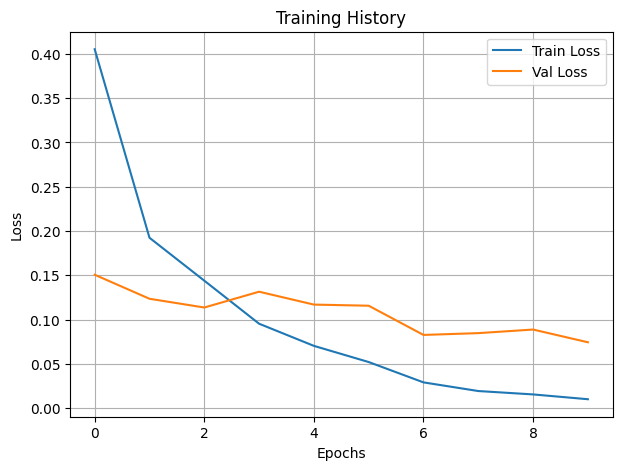

2025-07-04 12:23:39,584 - INFO - Training completed!


In [ ]:
# data_dir='/content/drive/MyDrive/data_img/img_classifier/data/images',
# model_path='/content/drive/MyDrive/data_img/img_classifier/models'

data_dir = './data/images'
model_path = './models/image_classifier'

classifier = AnimalImageClassifier(
    data_dir=data_dir,
    batch_size=32,
    learning_rate=1e-3,
    model_path=model_path
)
print("Starting training...")
trained_model = classifier.train(num_epochs=10)

2025-07-04 12:35:05,366 - INFO - Test loader initialized with 12997 samples.
Evaluating: 100%|██████████| 407/407 [01:13<00:00,  5.54it/s]


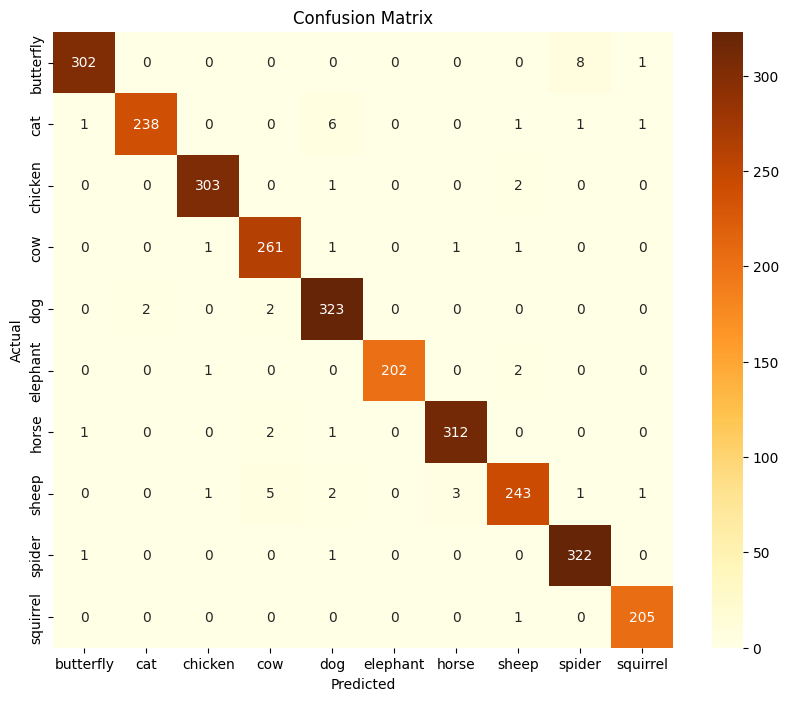

In [ ]:
classifier.setup_test_loader()
classifier.evaluate_test()
classifier.plot_confusion_matrix(classifier.test_loader)

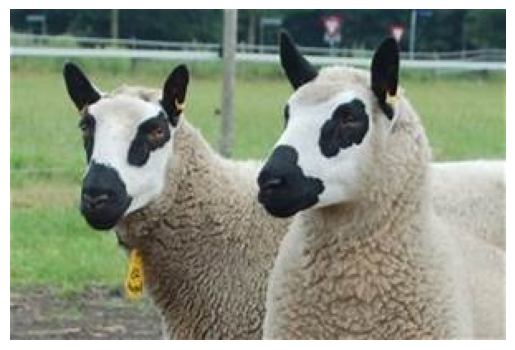

In [11]:
test_img = './data/images/test/sheep/OIP-jW9uZm9cox2kzddQLCN9NAHaE8.jpeg'
img = Image.open(test_img)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
pred_class, conf = classifier.predict(test_img)
print(f"Predicted: {pred_class} ({conf:.4f})")

Predicted: sheep (1.0000)
